In [1]:
import os
import random
import shutil
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import time
import cv2
import joblib
import tensorflow as tf
import seaborn as sns
import sklearn
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from scipy.stats import randint as sp_randint
from sklearn.utils import shuffle

2025-05-31 17:47:05.153436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748713625.343120      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748713625.400479      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-Learn version: {sklearn.__version__}")
print(f"Seaborn version: {sns.__version__}")

Notebook last run (end-to-end): 2025-05-31 17:48:06.995808
TensorFlow version: 2.18.0
NumPy version: 1.26.4
Pandas version: 2.2.3
Scikit-Learn version: 1.2.2
Seaborn version: 0.12.2


In [3]:
class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',      
    2: 'Speed limit (50km/h)',       
    3: 'Speed limit (60km/h)',      
    4: 'Speed limit (70km/h)',    
    5: 'Speed limit (80km/h)',      
    6: 'End of speed limit (80km/h)',     
    7: 'Speed limit (100km/h)',    
    8: 'Speed limit (120km/h)',     
    9: 'No passing',   
    10: 'No passing veh over 3.5 tons',     
    11: 'Right-of-way at intersection',     
    12: 'Priority road',    
    13: 'Yield',     
    14: 'Stop',       
    15: 'No vehicles',       
    16: 'Veh > 3.5 tons prohibited',       
    17: 'No entry',       
    18: 'General caution',     
    19: 'Dangerous curve left',      
    20: 'Dangerous curve right',   
    21: 'Double curve',      
    22: 'Bumpy road',     
    23: 'Slippery road',       
    24: 'Road narrows on the right',  
    25: 'Road work',    
    26: 'Traffic signals',      
    27: 'Pedestrians',     
    28: 'Children crossing',     
    29: 'Bicycles crossing',       
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',      
    32: 'End speed + passing limits',      
    33: 'Turn right ahead',     
    34: 'Turn left ahead',       
    35: 'Ahead only',      
    36: 'Go straight or right',      
    37: 'Go straight or left',      
    38: 'Keep right',     
    39: 'Keep left',      
    40: 'Roundabout mandatory',     
    41: 'End of no passing',      
    42: 'End no passing veh > 3.5 tons'
}

In [4]:
data_path = '/kaggle/input/gtsrb-german-traffic-sign'
train_data_path  = os.path.join(data_path, 'Train')
print(train_data_path)
test_data_path  = os.path.join(data_path, 'Test')
print(test_data_path)

/kaggle/input/gtsrb-german-traffic-sign/Train
/kaggle/input/gtsrb-german-traffic-sign/Test


In [5]:
train_image_paths = []
train_labels = []
for class_name in os.listdir(train_data_path):
    class_path = os.path.join(train_data_path, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for image_name in os.listdir(class_path):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):
            train_image_paths.append(os.path.join(class_path, image_name))
            train_labels.append(class_name)

In [6]:
train_df = pd.DataFrame({
    'path': train_image_paths,
    'label': train_labels
})


In [7]:
train_df

,path,label
0,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
1,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
2,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
3,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
4,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
...,...,...
39204,/kaggle/input/gtsrb-german-traffic-sign/Train/...,24
39205,/kaggle/input/gtsrb-german-traffic-sign/Train/...,24
39206,/kaggle/input/gtsrb-german-traffic-sign/Train/...,24
39207,/kaggle/input/gtsrb-german-traffic-sign/Train/...,24


In [8]:
random_images_sample = random.sample(train_image_paths, 16)

  0%|          | 0/16 [00:00<?, ?it/s]

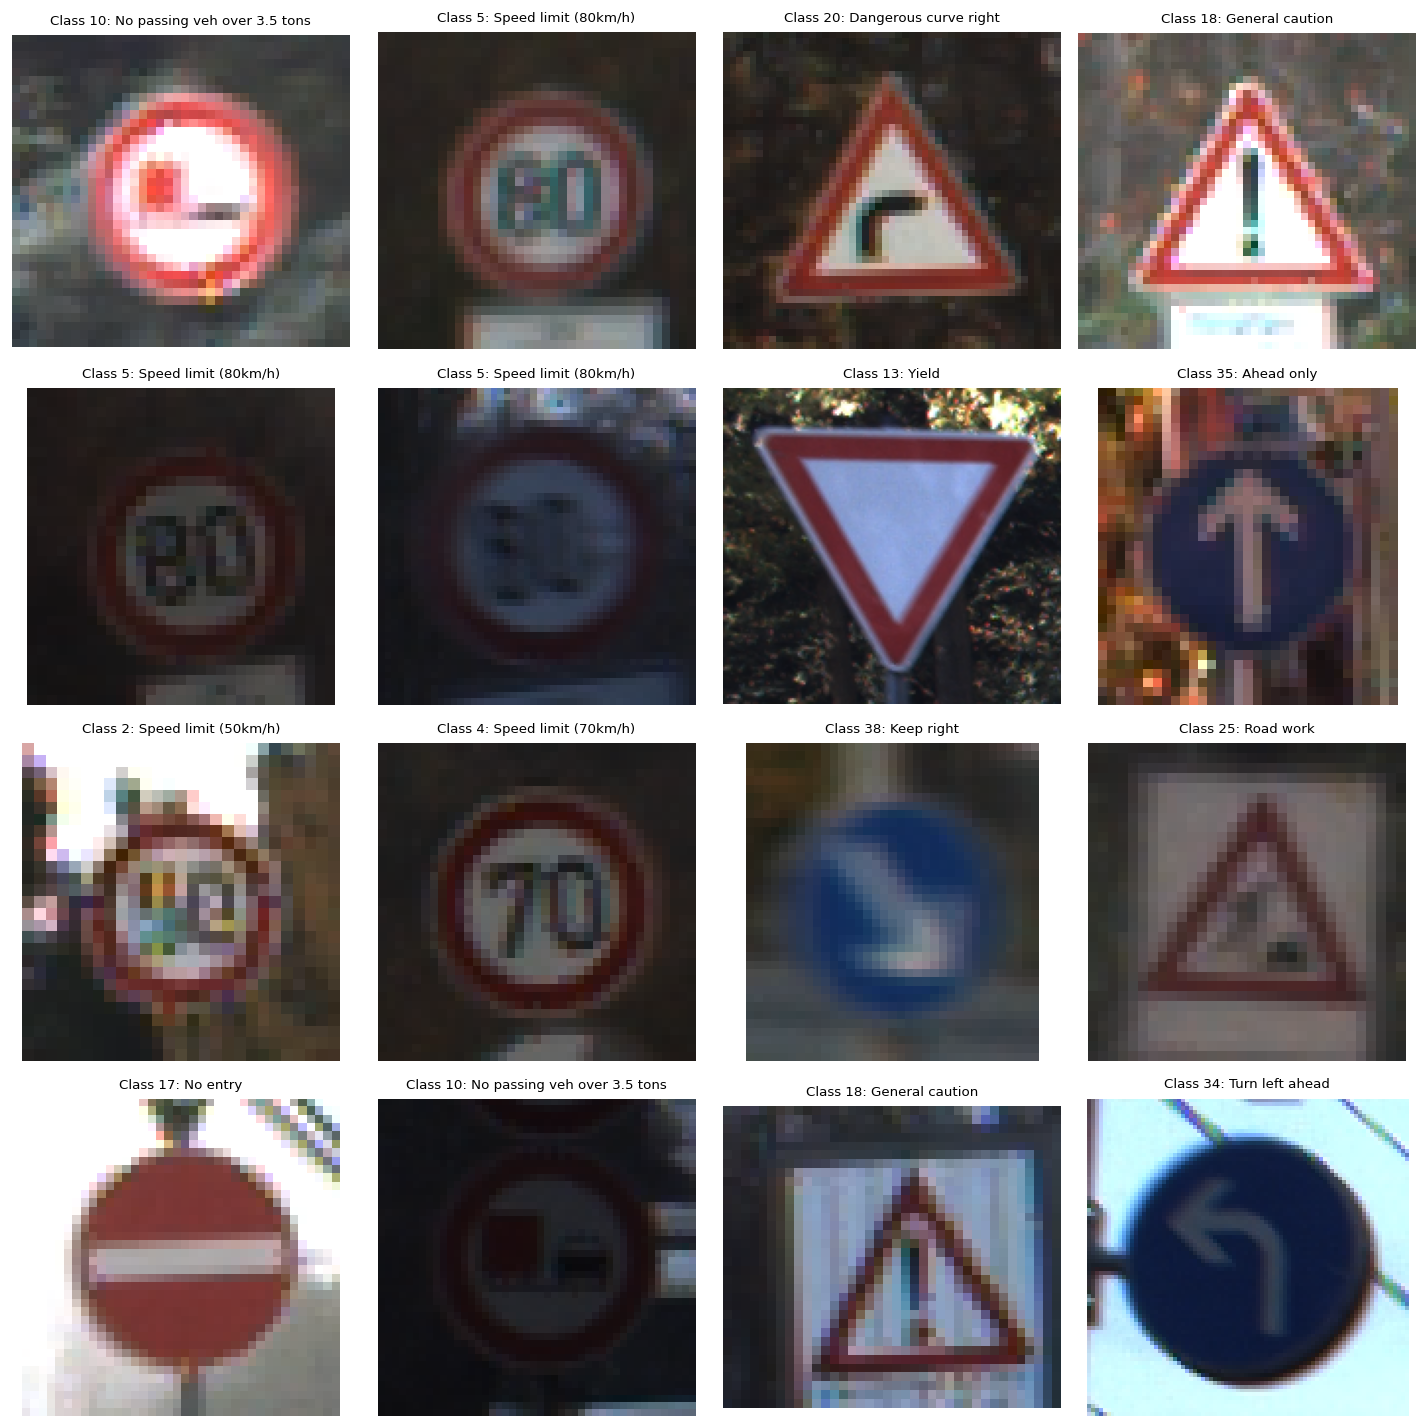

In [9]:
plt.figure(figsize=(12, 12), dpi=120)
for i, img_path in enumerate(tqdm(random_images_sample)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    class_id = int(os.path.dirname(img_path).split('/')[-1])
    plt.title(f'Class {class_id}: {class_names[class_id]}', fontsize=8)

plt.tight_layout()
plt.show()

In [10]:
train_split_df, val_df = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42,
    stratify=train_df['label']  
)

Training set: 31367 samples (80.0%)
Validation set: 7842 samples (20.0%)


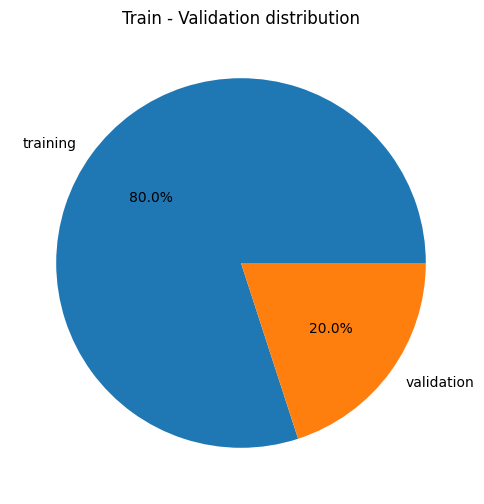

In [11]:
print(f"Training set: {len(train_split_df)} samples ({len(train_split_df)/len(train_df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(train_df)*100:.1f}%)")
plt.figure(figsize=(6, 6))
plt.pie([len(train_split_df), len(val_df)], 
        labels=["training", "validation"],
        autopct='%1.1f%%')
plt.title('Train - Validation distribution')
plt.show()


In [12]:
train_split_df

,path,label
11057,/kaggle/input/gtsrb-german-traffic-sign/Train/...,36
29434,/kaggle/input/gtsrb-german-traffic-sign/Train/...,1
2508,/kaggle/input/gtsrb-german-traffic-sign/Train/...,17
39097,/kaggle/input/gtsrb-german-traffic-sign/Train/...,24
15641,/kaggle/input/gtsrb-german-traffic-sign/Train/...,8
...,...,...
5775,/kaggle/input/gtsrb-german-traffic-sign/Train/...,35
5923,/kaggle/input/gtsrb-german-traffic-sign/Train/...,35
32005,/kaggle/input/gtsrb-german-traffic-sign/Train/...,4
5536,/kaggle/input/gtsrb-german-traffic-sign/Train/...,35


In [13]:
val_df

,path,label
38821,/kaggle/input/gtsrb-german-traffic-sign/Train/...,29
14903,/kaggle/input/gtsrb-german-traffic-sign/Train/...,8
1867,/kaggle/input/gtsrb-german-traffic-sign/Train/...,17
4233,/kaggle/input/gtsrb-german-traffic-sign/Train/...,2
37818,/kaggle/input/gtsrb-german-traffic-sign/Train/...,37
...,...,...
32491,/kaggle/input/gtsrb-german-traffic-sign/Train/...,4
37706,/kaggle/input/gtsrb-german-traffic-sign/Train/...,11
9574,/kaggle/input/gtsrb-german-traffic-sign/Train/...,5
34530,/kaggle/input/gtsrb-german-traffic-sign/Train/...,9


In [14]:
test_csv_path = os.path.join(data_path, 'Test.csv')
test_df = pd.read_csv(test_csv_path)
test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(data_path, x))
print(f"Test set: {len(test_df)} samples")

Test set: 12630 samples


In [15]:
def preprocess_rf(img_path, target_size = (32, 32)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img_flat = img.flatten() / 255.0 
    return img_flat

In [16]:
print("Processing training images:")
X_train = np.array([preprocess_rf(img_path) for img_path in tqdm(train_split_df['path'])])
y_train = np.array([int(label) for label in train_split_df['label']])

print("Processing validation images:")
X_val = np.array([preprocess_rf(img_path) for img_path in tqdm(val_df['path'])])
y_val = np.array([int(label) for label in val_df['label']])

print("Processing test images:")
X_test = np.array([preprocess_rf(os.path.join(data_path, path)) 
                   for path in tqdm(test_df['Path'])])
y_test = test_df['ClassId'].values

Processing training images:


  0%|          | 0/31367 [00:00<?, ?it/s]

Processing validation images:


  0%|          | 0/7842 [00:00<?, ?it/s]

Processing test images:


  0%|          | 0/12630 [00:00<?, ?it/s]

In [17]:
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (31367, 3072)
Validation data shape: (7842, 3072)
Test data shape: (12630, 3072)


In [ ]:
param_grid = {
    "n_estimators": sp_randint(10, 200),
    "max_depth": [3, 5, 10, None],
    "max_features": ['sqrt', 'log2', None],  
    "min_samples_split": sp_randint(2, 11),
    "criterion": ["gini", "entropy"]
}

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rsearch = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1,
)

In [ ]:
start_ts = time.time()
rsearch.fit(X_train, y_train)

In [ ]:
print(f"CV Runtime: {time.time() - start_ts:.2f} seconds")
print(f'Best RandomizedSearchCV score: {rsearch.best_score_:.4f}')
print(f'Best parameters:\n {rsearch.best_params_}')

In [ ]:
scorers = {'Accuracy': 'accuracy'}
start_ts = time.time()
scores = cross_validate(rsearch.best_estimator_, X_train, y_train, scoring=scorers, cv=5)
scores_Acc = scores['test_Accuracy']
print(f"Random Forest (hypertuned) CV Accuracy: {scores_Acc.mean():.4f} (+/- {scores_Acc.std() * 2:.4f})")
print(f"CV Runtime: {time.time() - start_ts:.2f} seconds")


In [ ]:
start_ts = time.time()
best_rf = rsearch.best_estimator_
val_acc = best_rf.score(X_val, y_val)
print(f'Random Forest Validation Accuracy: {val_acc:.4f}')
print(f"Validation Runtime: {time.time() - start_ts:.2f} seconds")

val_pred = best_rf.predict(X_val)
print("\nRandom Forest classification report on validation data:")
print(classification_report(y_val, val_pred))

In [ ]:
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_val, val_pred, average='weighted')
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {fbeta_score:.4f}")

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Random Forest Validation Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [ ]:
test_pred = best_rf.predict(X_test)
test_acc = best_rf.score(X_test, y_test)
print(f'Random Forest Test Accuracy: {test_acc:.4f}')

print("\nRandom Forest classification report on test data:")
print(classification_report(y_test, test_pred))

In [ ]:
cm_test = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d')
plt.title('Random Forest Test Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import joblib
joblib.dump(best_rf, 'random_forest_traffic_sign_model.joblib')
print("Model saved as 'random_forest_traffic_sign_model.joblib'") 

In [ ]:
from IPython.display import FileLink
FileLink(r'confusion_matrix.png')

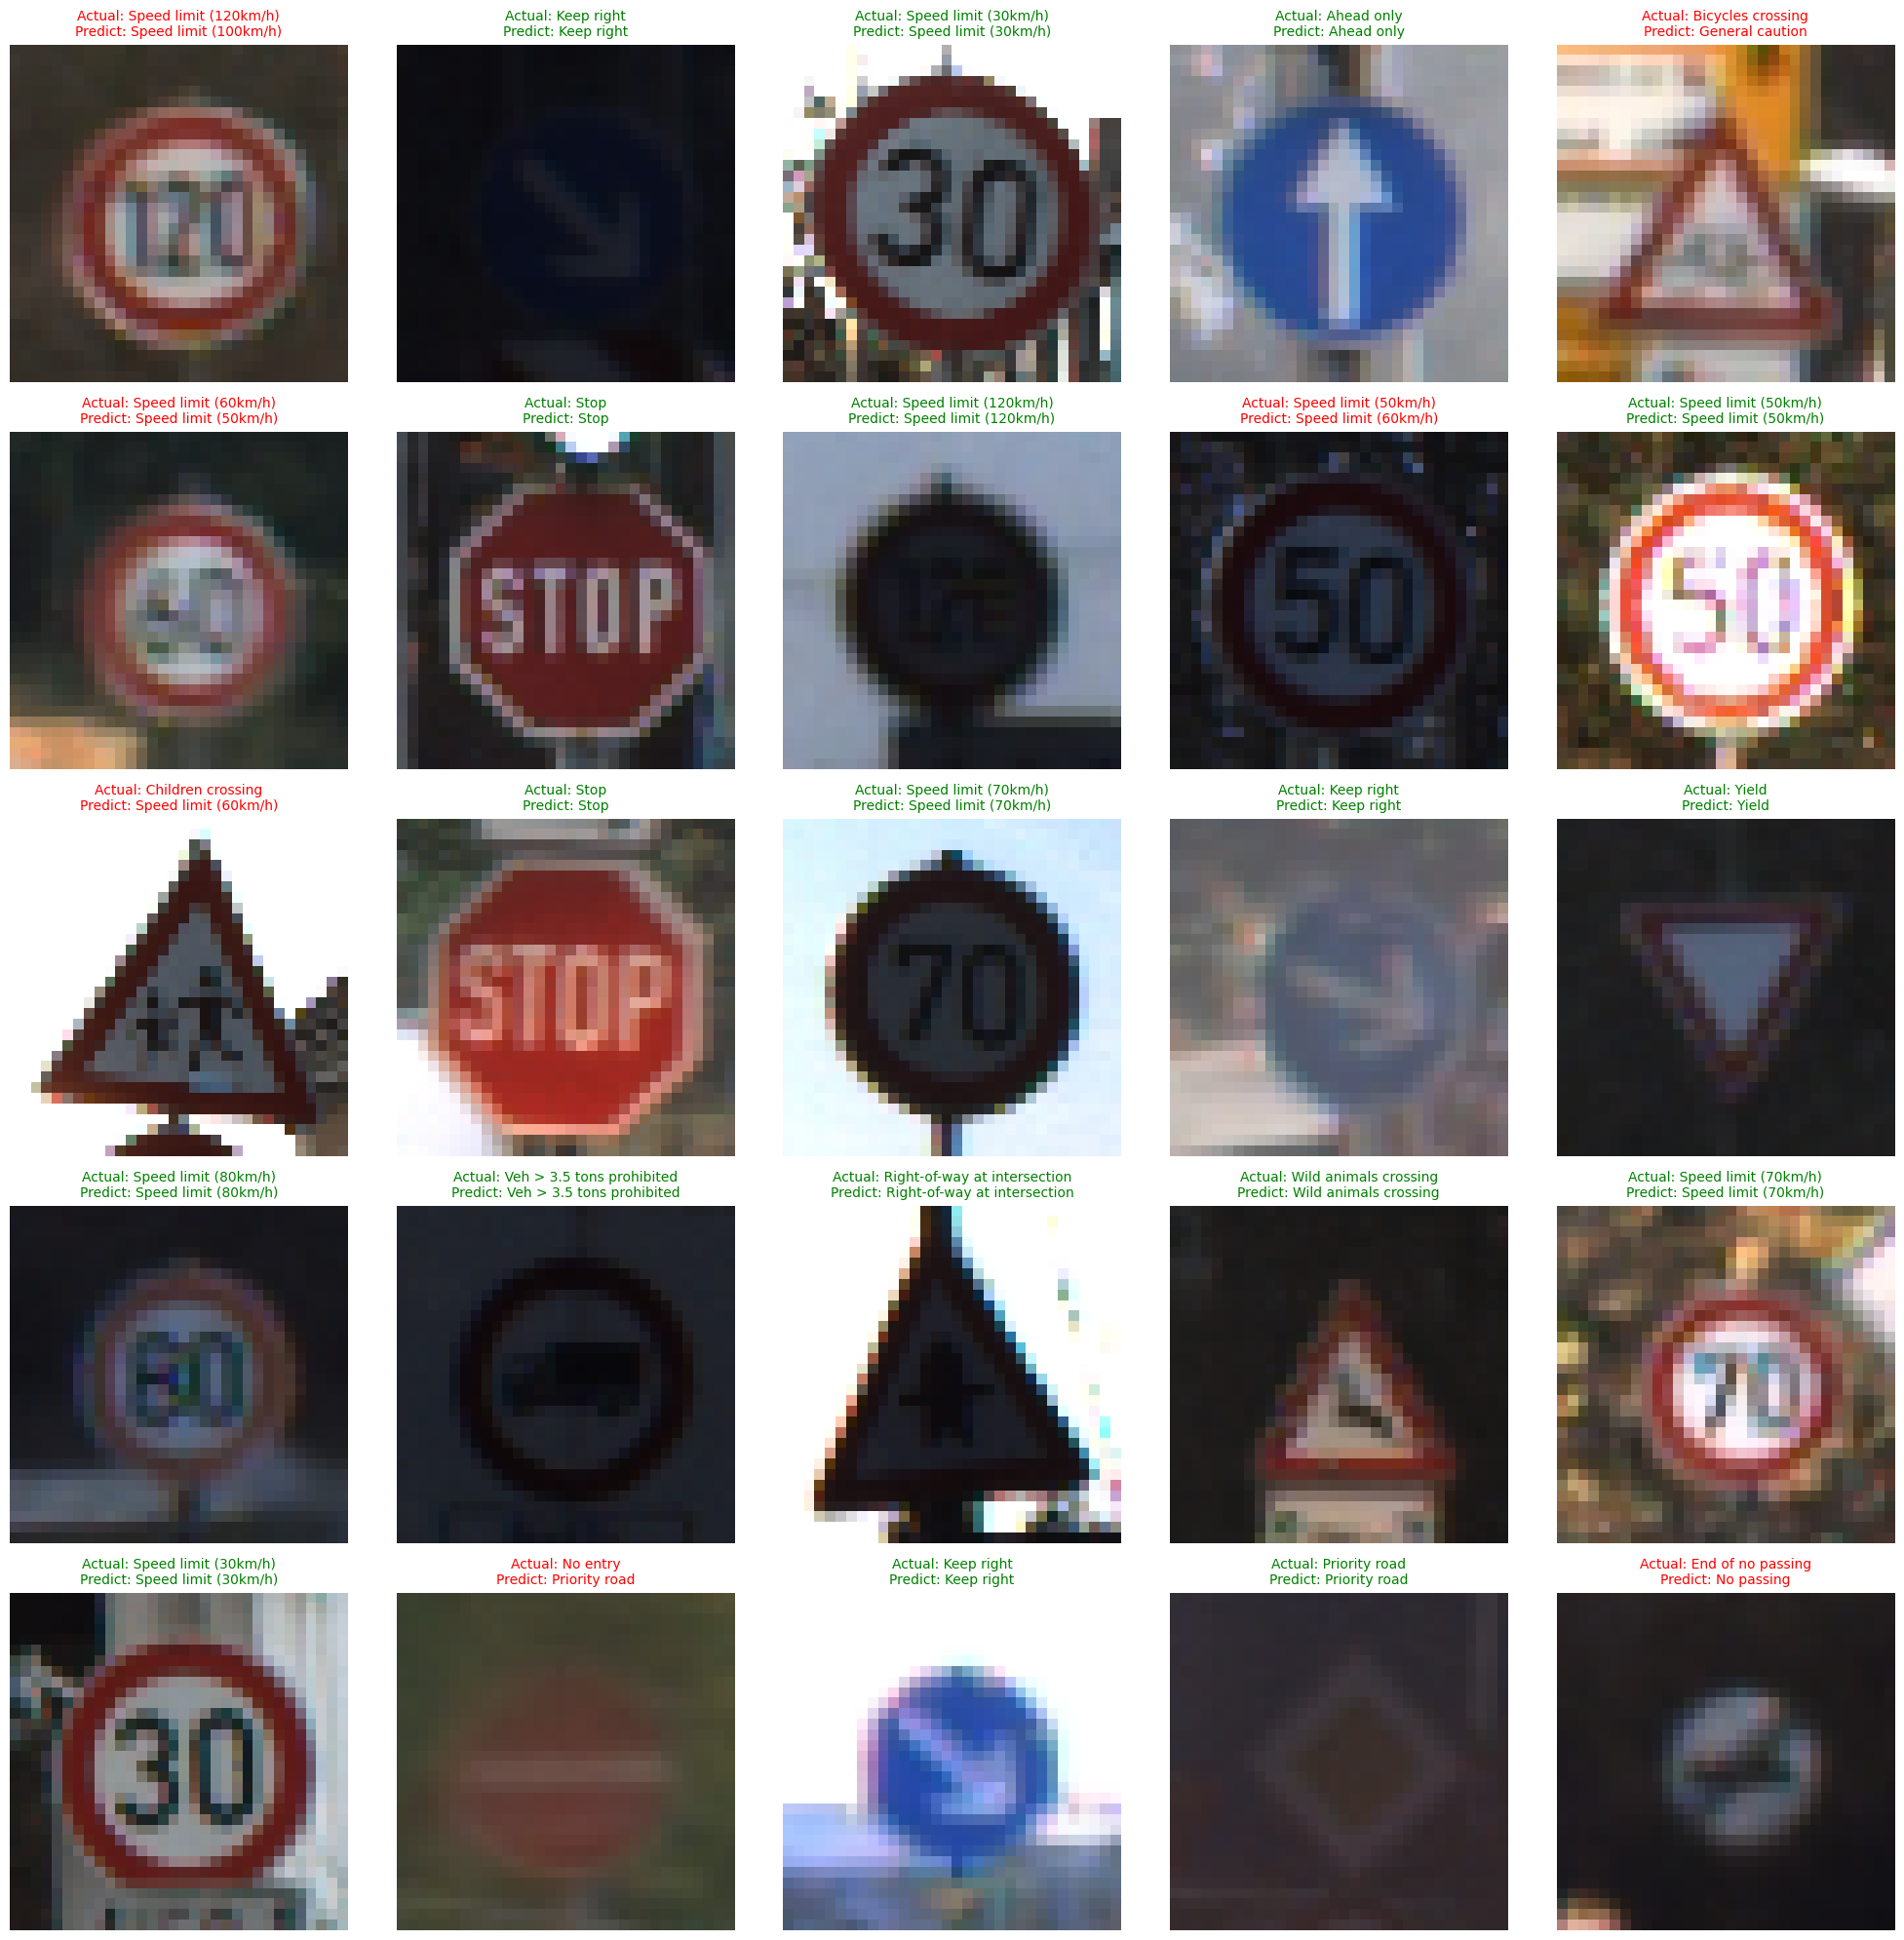

In [18]:
def visualize_test_predictions(X_test, y_test, model, class_names, num_images=25):
    y_pred_proba = model.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    indices = np.random.choice(len(X_test), min(num_images, len(X_test)), replace=False)
    n_cols = 5
    n_rows = (num_images + n_cols - 1) // n_cols
    plt.figure(figsize=(20, 4*n_rows))
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        img = X_test[idx].reshape(32, 32, 3)
        plt.imshow(img)
        plt.axis('off')
        true_class = int(y_test[idx])
        pred_class = int(y_pred[idx])
        true_name = class_names[true_class]
        pred_name = class_names[pred_class]
        
        color = 'green' if true_class == pred_class else 'red'
        plt.title(f"Actual: {true_name}\nPredict: {pred_name}", color=color, fontsize=10)
    
    plt.tight_layout()
    plt.show()

rf_model = joblib.load('/kaggle/input/random_forest/scikitlearn/default/1/random_forest_traffic_sign_model.joblib')
visualize_test_predictions(X_test, y_test, rf_model, class_names)